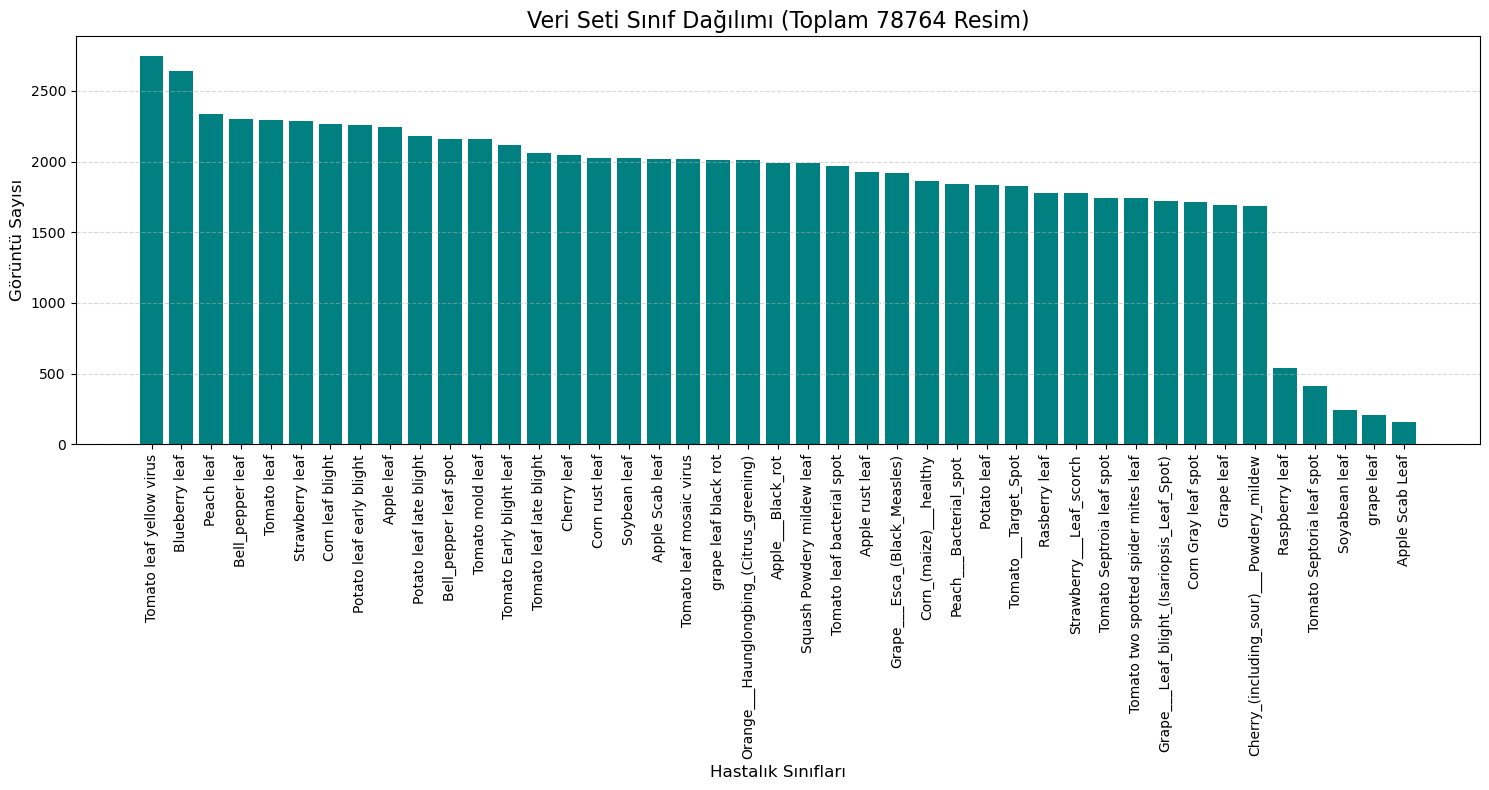

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

VERI_DOSYASI = r'C:\Users\Enes Arslan\Bitki Projesi\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv'

df = pd.read_csv(VERI_DOSYASI)

sinif_sayilari = df['class'].value_counts()

plt.figure(figsize=(15, 8))
plt.bar(sinif_sayilari.index, sinif_sayilari.values, color='teal')


plt.xticks(rotation=90) 
plt.title(f"Veri Seti Sınıf Dağılımı (Toplam {len(df)} Resim)", fontsize=16)
plt.xlabel("Hastalık Sınıfları", fontsize=12)
plt.ylabel("Görüntü Sayısı", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import random
import time

# --- DONANIM AYARLARI ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kodun Çalıştığı Cihaz: {device}")
if torch.cuda.is_available():
    print(f"Aktif Ekran Kartı: {torch.cuda.get_device_name(0)}")

# --- SABİTLER VE YOLLAR ---
CSV_DOSYASI = r'C:\Users\Enes Arslan\Bitki Projesi\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv'
ANA_KLASOR = r'C:\Users\Enes Arslan\Bitki Projesi\New Plant Diseases Dataset(Augmented)\train'

BATCH_SIZE = 16 
LEARNING_RATE = 0.001
EPOCHS = 15
RESIM_BOYUTU = 128 

# --- VERİ SETİ SINIFI ---
class BitkiVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}

    def __len__(self):
        return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi = str(self.veriler.iloc[idx, 0])
            sinif_ismi = str(self.veriler.iloc[idx, 1])
            
            if "?" in dosya_adi: 
                dosya_adi = dosya_adi.split('?')[0]
            
            yollar = [
                os.path.join(self.root_dir, sinif_ismi, dosya_adi),
                os.path.join(self.root_dir, dosya_adi),
                os.path.join(self.root_dir, sinif_ismi, dosya_adi[:-4] + ".jpg")
            ]
            
            hedef_yol = None
            for yol in yollar:
                if os.path.exists(yol):
                    hedef_yol = yol
                    break
            
            if hedef_yol is None: 
                raise FileNotFoundError(f"Dosya bulunamadı: {dosya_adi}")

            image = Image.open(hedef_yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            
            if self.transform: 
                image = self.transform(image)
            
            return image, label
            
        except Exception:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)

# --- ANA ÇALIŞMA BLOĞU ---
if __name__ == '__main__':
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    print("Veri Seti Yükleniyor...")
    try:
        dataset = BitkiVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
        
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        
        print(f"Eğitim Verisi: {len(train_dataset)} | Doğrulama Verisi: {len(val_dataset)}")
        
        # --- MODEL: RESNET50 ---
        print("\nResNet50 Hazırlanıyor...")
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        num_ftrs = model.fc.in_features
        num_classes = len(dataset.sinif_isimleri)
        model.fc = nn.Linear(num_ftrs, num_classes)
        
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        print("\nEĞİTİM BAŞLIYOR... (Sadece Epoch Sonuçları Gösterilecek)")
        print("-" * 60)

        for epoch in range(EPOCHS):
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            
            start_time = time.time()
            
            # --- EĞİTİM DÖNGÜSÜ ---
            for i, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # SİLİNEN KISIM: Buradaki "if (i+1) % 50 == 0" bloğu kaldırıldı.
            
            # --- EPOCH SONU RAPORU ---
            avg_train_loss = train_loss / len(train_loader)
            train_acc = 100 * correct / total
            elapsed_time = time.time() - start_time
            
            print(f"✅ Epoch {epoch+1}/{EPOCHS} Tamamlandı ({elapsed_time:.1f} sn)")
            print(f"   Train Acc: %{train_acc:.2f} | Loss: {avg_train_loss:.4f}")
            
            # --- VALIDATION ---
            model.eval()
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            
            val_acc = 100 * val_correct / val_total
            print(f"   VAL ACC  : %{val_acc:.2f}")
            print("-" * 60)

        torch.save(model.state_dict(), 'resnet50_bitki_projesi_final.pth')
        print("Model Başarıyla Kaydedildi: resnet50_bitki_projesi_final.pth")

    except FileNotFoundError:
        print("\nHATA: Dosya yolları bulunamadı!")
        print(f"Lütfen şu yolun doğruluğunu kontrol et: {ANA_KLASOR}")

Kodun Çalıştığı Cihaz: cuda
Aktif Ekran Kartı: NVIDIA GeForce RTX 4060 Laptop GPU
Veri Seti Yükleniyor...
Eğitim Verisi: 63011 | Doğrulama Verisi: 15753

ResNet50 Hazırlanıyor...

EĞİTİM BAŞLIYOR... (Sadece Epoch Sonuçları Gösterilecek)
------------------------------------------------------------
✅ Epoch 1/15 Tamamlandı (457.5 sn)
   Train Acc: %86.68 | Loss: 0.4603
   VAL ACC  : %91.41
------------------------------------------------------------
✅ Epoch 2/15 Tamamlandı (463.3 sn)
   Train Acc: %94.39 | Loss: 0.1874
   VAL ACC  : %94.81
------------------------------------------------------------
✅ Epoch 3/15 Tamamlandı (475.0 sn)
   Train Acc: %96.29 | Loss: 0.1237
   VAL ACC  : %91.73
------------------------------------------------------------
✅ Epoch 4/15 Tamamlandı (459.7 sn)
   Train Acc: %97.21 | Loss: 0.0904
   VAL ACC  : %97.40
------------------------------------------------------------
✅ Epoch 5/15 Tamamlandı (469.7 sn)
   Train Acc: %97.88 | Loss: 0.0698
   VAL ACC  : %96.3

In [3]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import random
from sklearn.metrics import f1_score, accuracy_score, classification_report

# --- YOLLAR VE AYARLAR ---
CSV_DOSYASI = r'C:\Users\Enes Arslan\Bitki Projesi\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv'
ANA_KLASOR = r'C:\Users\Enes Arslan\Bitki Projesi\New Plant Diseases Dataset(Augmented)\train'
MODEL_PATH = "resnet50_bitki_projesi_final.pth" 
BATCH_SIZE = 16 
RESIM_BOYUTU = 128

# GPU Kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Test işlemi için kullanılan cihaz: {device}")
if torch.cuda.is_available():
    print(f"Ekran Kartı: {torch.cuda.get_device_name(0)}")

# --- VERİ SETİ SINIFI ---
class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi = str(self.veriler.iloc[idx, 0])
            sinif_ismi = str(self.veriler.iloc[idx, 1])
            if "?" in dosya_adi: dosya_adi = dosya_adi.split('?')[0]
            
            yollar = [os.path.join(self.root_dir, sinif_ismi, dosya_adi),
                      os.path.join(self.root_dir, dosya_adi),
                      os.path.join(self.root_dir, sinif_ismi, dosya_adi[:-4] + ".jpg")]
            
            hedef_yol = None
            for yol in yollar:
                if os.path.exists(yol):
                    hedef_yol = yol
                    break
            
            if hedef_yol is None: raise FileNotFoundError()

            image = Image.open(hedef_yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform: image = self.transform(image)
            return image, label
        except:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)

# --- ANA TEST BLOĞU ---
if __name__ == '__main__':
    print("Test Verileri Hazırlanıyor...")
    
    # ResNet için normalizasyon ayarları
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = TankVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    _, val_dataset = random_split(dataset, [train_size, val_size])
    
    test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"Test Edilecek Görüntü Sayısı: {len(val_dataset)}")
    
    # --- MODELİ YÜKLEME ---
    num_classes = len(dataset.sinif_isimleri)
    
    # Model mimarisini oluştur
    model = models.resnet50(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)
    
    if os.path.exists(MODEL_PATH):
        print(f"Model yükleniyor: {MODEL_PATH}")
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        model.eval() 
    else:
        print(f"HATA: '{MODEL_PATH}' bulunamadı! Dosya adını kontrol et.")
        exit()

    print("\nTEST BAŞLIYOR... (Lütfen bekleyin)")
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            if (i+1) % 50 == 0:
                print(f"   İşlenen paket: {i+1}...")

    # Raporlama
    acc = accuracy_score(all_labels, all_preds)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    print("\n" + "="*50)
    print("MODEL PERFORMANS RAPORU")
    print("="*50)
    print(f"Genel Doğruluk (Accuracy): %{acc*100:.2f}")
    print(f"Genel F1 Skoru (Weighted): {f1_weighted:.4f}")
    print(f"Genel F1 Skoru (Macro)   : {f1_macro:.4f}")
    print("-" * 50)
    
    print("\nHASTALIK BAZLI DETAYLI RAPOR:")
    
    # --- HATA DÜZELTME KISMI BURASI ---
    # Sınıf listesini sayısal indeks olarak (0, 1, 2... 42) oluşturuyoruz
    class_indices = list(range(len(dataset.sinif_isimleri)))
    
    # classification_report'a 'labels' parametresini ekleyerek 
    # "Test setinde olmasa bile bu sınıfları da rapora dahil et" diyoruz.
    print(classification_report(
        all_labels, 
        all_preds, 
        labels=class_indices, 
        target_names=dataset.sinif_isimleri,
        zero_division=0 # Test setinde hiç olmayan sınıflar için hata vermek yerine 0 yaz
    ))

Test işlemi için kullanılan cihaz: cuda
Ekran Kartı: NVIDIA GeForce RTX 4060 Laptop GPU
Test Verileri Hazırlanıyor...
Test Edilecek Görüntü Sayısı: 15753
Model yükleniyor: resnet50_bitki_projesi_final.pth

TEST BAŞLIYOR... (Lütfen bekleyin)
   İşlenen paket: 50...
   İşlenen paket: 100...
   İşlenen paket: 150...
   İşlenen paket: 200...
   İşlenen paket: 250...
   İşlenen paket: 300...
   İşlenen paket: 350...
   İşlenen paket: 400...
   İşlenen paket: 450...
   İşlenen paket: 500...
   İşlenen paket: 550...
   İşlenen paket: 600...
   İşlenen paket: 650...
   İşlenen paket: 700...
   İşlenen paket: 750...
   İşlenen paket: 800...
   İşlenen paket: 850...
   İşlenen paket: 900...
   İşlenen paket: 950...

MODEL PERFORMANS RAPORU
Genel Doğruluk (Accuracy): %99.19
Genel F1 Skoru (Weighted): 0.9919
Genel F1 Skoru (Macro)   : 0.9890
--------------------------------------------------

HASTALIK BAZLI DETAYLI RAPOR:
                                            precision    recall  f1-score   

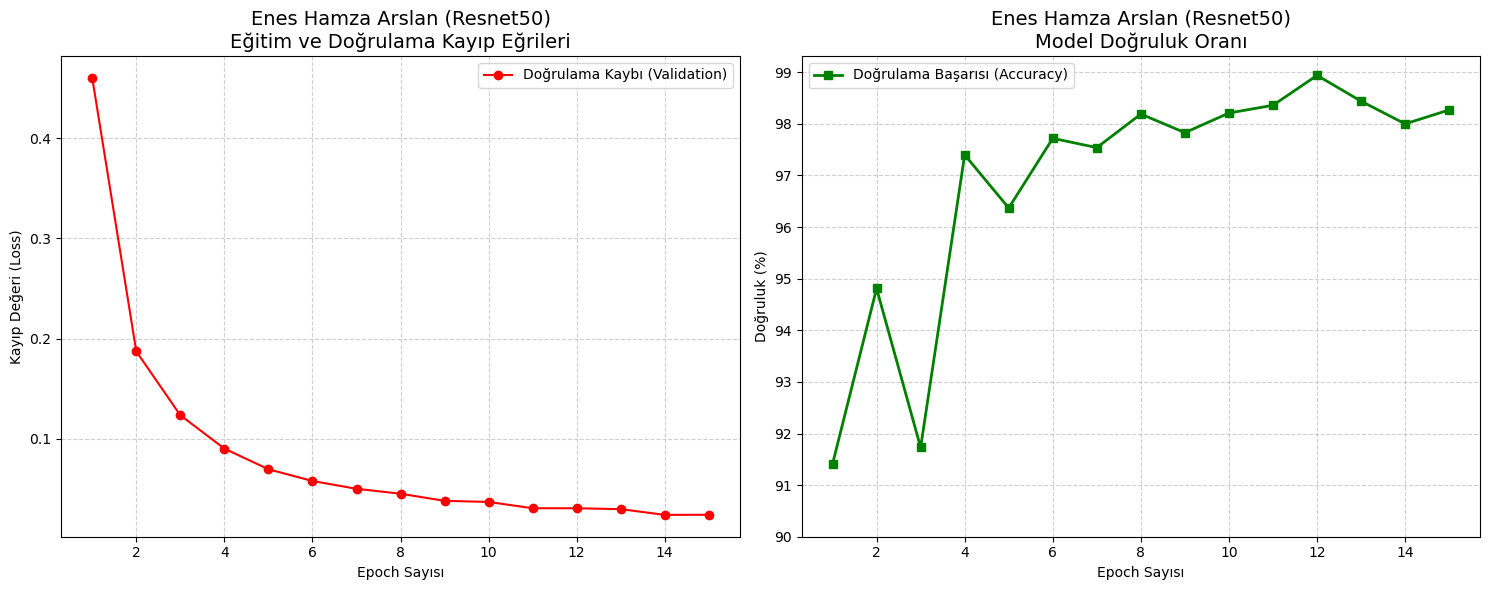

In [4]:
import matplotlib.pyplot as plt

# İstenilen değişiklik burada yapıldı
USER_INFO = "Enes Hamza Arslan (Resnet50)"

epochs = list(range(1, 16))
# NOT: Aşağıdaki değerler örnek verilerdir. 
# Kendi eğitiminizden çıkan loss ve accuracy değerlerini buraya yapıştırmanız gerekebilir.
val_losses = [0.4603,0.1874,0.1237,0.0904,0.0698,0.0581,0.0503,0.0454,0.0383,0.0372, 0.0309, 0.0309, 0.0300, 0.0243, 0.0244]
accuracies =  [91.41, 94.81, 91.73, 97.40, 96.37, 97.72, 97.54, 98.19, 97.83, 98.21, 98.36, 98.94, 98.44, 98.00, 98.27]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, 'r-o', label='Doğrulama Kaybı (Validation)')

plt.title(f'{USER_INFO}\nEğitim ve Doğrulama Kayıp Eğrileri', fontsize=14)

plt.xlabel('Epoch Sayısı')
plt.ylabel('Kayıp Değeri (Loss)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'g-s', linewidth=2, label='Doğrulama Başarısı (Accuracy)')

plt.title(f'{USER_INFO}\nModel Doğruluk Oranı', fontsize=14)

plt.xlabel('Epoch Sayısı')
plt.ylabel('Doğruluk (%)')
plt.yticks(range(90, 100, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
# MobileNet ağırlıklarını doğru isimle (alt çizgili) import ediyoruz
from torchvision.models import MobileNet_V3_Large_Weights 
from PIL import Image
import random
import time

# --- DONANIM VE PERFORMANS AYARLARI ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kodun Çalıştığı Cihaz: {device}")

if torch.cuda.is_available():
    print(f"Aktif Ekran Kartı: {torch.cuda.get_device_name(0)}")
    # RTX serisi kartlar için ekstra hızlandırma
    torch.backends.cudnn.benchmark = True 

# --- SABİTLER VE YOLLAR ---
CSV_DOSYASI = r'C:\Users\Enes Arslan\Bitki Projesi\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv'
ANA_KLASOR = r'C:\Users\Enes Arslan\Bitki Projesi\New Plant Diseases Dataset(Augmented)\train'

BATCH_SIZE = 16 
LEARNING_RATE = 0.001
EPOCHS = 15
RESIM_BOYUTU = 128 

# --- VERİ SETİ SINIFI ---
class BitkiVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}

    def __len__(self):
        return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi = str(self.veriler.iloc[idx, 0])
            sinif_ismi = str(self.veriler.iloc[idx, 1])
            
            if "?" in dosya_adi: 
                dosya_adi = dosya_adi.split('?')[0]
            
            yollar = [
                os.path.join(self.root_dir, sinif_ismi, dosya_adi),
                os.path.join(self.root_dir, dosya_adi),
                os.path.join(self.root_dir, sinif_ismi, dosya_adi[:-4] + ".jpg")
            ]
            
            hedef_yol = None
            for yol in yollar:
                if os.path.exists(yol):
                    hedef_yol = yol
                    break
            
            if hedef_yol is None: 
                raise FileNotFoundError(f"Dosya bulunamadı: {dosya_adi}")

            image = Image.open(hedef_yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            
            if self.transform: 
                image = self.transform(image)
            
            return image, label
            
        except Exception:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)

# --- ANA ÇALIŞMA BLOĞU ---
if __name__ == '__main__':
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    print("Veri Seti Yükleniyor...")
    try:
        dataset = BitkiVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
        
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        # pin_memory=True: GPU'ya veri aktarımını hızlandırır (GPU varsa)
        use_pin_memory = torch.cuda.is_available()
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=use_pin_memory)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=use_pin_memory)
        
        print(f"Eğitim Verisi: {len(train_dataset)} | Doğrulama Verisi: {len(val_dataset)}")
        
        # --- MODEL: MOBILENET V3 (MODERN YÖNTEM) ---
        print("\nMobileNetV3 (Large) Hazırlanıyor...")
        
        # EN OPTİMAL YÖNTEM:
        # Doğrudan ağırlık nesnesini veriyoruz. Bu sayede 'UserWarning' almazsınız.
        # Önceki hatanızın sebebi "MobileNetV3..." yazmanızdı, doğrusu "MobileNet_V3..." (arada tire var).
        model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
        
        num_ftrs = model.classifier[-1].in_features
        num_classes = len(dataset.sinif_isimleri)
        model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
        
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        print("\nEĞİTİM BAŞLIYOR... (Sadece Epoch Sonuçları Gösterilecek)")
        print("-" * 60)

        for epoch in range(EPOCHS):
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            
            start_time = time.time()
            
            for i, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            avg_train_loss = train_loss / len(train_loader)
            train_acc = 100 * correct / total
            elapsed_time = time.time() - start_time
            
            print(f"✅ Epoch {epoch+1}/{EPOCHS} Tamamlandı ({elapsed_time:.1f} sn)")
            print(f"   Train Acc: %{train_acc:.2f} | Loss: {avg_train_loss:.4f}")
            
            # --- VALIDATION ---
            model.eval()
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            
            val_acc = 100 * val_correct / val_total
            print(f"   VAL ACC  : %{val_acc:.2f}")
            print("-" * 60)

        torch.save(model.state_dict(), 'mobilenetv3_bitki_projesi_final.pth')
        print("Model Başarıyla Kaydedildi: mobilenetv3_bitki_projesi_final.pth")

    except FileNotFoundError:
        print("\nHATA: Dosya yolları bulunamadı!")
        print(f"Lütfen şu yolun doğruluğunu kontrol et: {ANA_KLASOR}")

Kodun Çalıştığı Cihaz: cuda
Aktif Ekran Kartı: NVIDIA GeForce RTX 4060 Laptop GPU
Veri Seti Yükleniyor...
Eğitim Verisi: 63011 | Doğrulama Verisi: 15753

MobileNetV3 (Large) Hazırlanıyor...


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to C:\Users\Enes Arslan/.cache\torch\hub\checkpoints\mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:01<00:00, 15.7MB/s]



EĞİTİM BAŞLIYOR... (Sadece Epoch Sonuçları Gösterilecek)
------------------------------------------------------------
✅ Epoch 1/15 Tamamlandı (414.4 sn)
   Train Acc: %87.17 | Loss: 0.4500
   VAL ACC  : %88.26
------------------------------------------------------------
✅ Epoch 2/15 Tamamlandı (407.9 sn)
   Train Acc: %93.08 | Loss: 0.2427
   VAL ACC  : %93.18
------------------------------------------------------------
✅ Epoch 3/15 Tamamlandı (410.6 sn)
   Train Acc: %94.48 | Loss: 0.1958
   VAL ACC  : %95.91
------------------------------------------------------------
✅ Epoch 4/15 Tamamlandı (401.7 sn)
   Train Acc: %95.67 | Loss: 0.1565
   VAL ACC  : %94.01
------------------------------------------------------------
✅ Epoch 5/15 Tamamlandı (410.3 sn)
   Train Acc: %95.96 | Loss: 0.1471
   VAL ACC  : %97.35
------------------------------------------------------------
✅ Epoch 6/15 Tamamlandı (405.5 sn)
   Train Acc: %96.45 | Loss: 0.1309
   VAL ACC  : %97.53
------------------------

In [8]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import random
from sklearn.metrics import f1_score, accuracy_score, classification_report

# --- YOLLAR VE AYARLAR (Enes Arslan & MobileNetV3) ---
CSV_DOSYASI = r'C:\Users\Enes Arslan\Bitki Projesi\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv'
ANA_KLASOR = r'C:\Users\Enes Arslan\Bitki Projesi\New Plant Diseases Dataset(Augmented)\train'
MODEL_PATH = "mobilenetv3_bitki_projesi_final.pth" 
BATCH_SIZE = 16 
RESIM_BOYUTU = 128

# GPU Kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Test işlemi için kullanılan cihaz: {device}")
if torch.cuda.is_available():
    print(f"Ekran Kartı: {torch.cuda.get_device_name(0)}")

# --- VERİ SETİ SINIFI ---
class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi = str(self.veriler.iloc[idx, 0])
            sinif_ismi = str(self.veriler.iloc[idx, 1])
            if "?" in dosya_adi: dosya_adi = dosya_adi.split('?')[0]
            
            yollar = [os.path.join(self.root_dir, sinif_ismi, dosya_adi),
                      os.path.join(self.root_dir, dosya_adi),
                      os.path.join(self.root_dir, sinif_ismi, dosya_adi[:-4] + ".jpg")]
            
            hedef_yol = None
            for yol in yollar:
                if os.path.exists(yol):
                    hedef_yol = yol
                    break
            
            if hedef_yol is None: raise FileNotFoundError()

            image = Image.open(hedef_yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform: image = self.transform(image)
            return image, label
        except:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)

# --- ANA TEST BLOĞU ---
if __name__ == '__main__':
    print("Test Verileri Hazırlanıyor...")
    
    # MobileNetV3 (ImageNet) için normalizasyon ayarları
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = TankVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    _, val_dataset = random_split(dataset, [train_size, val_size])
    
    test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"Test Edilecek Görüntü Sayısı: {len(val_dataset)}")
    
    # --- MODELİ YÜKLEME (MobileNetV3) ---
    num_classes = len(dataset.sinif_isimleri)
    
    # Model iskeletini oluşturuyoruz (Weights=None çünkü kendi dosyamızı yükleyeceğiz)
    model = models.mobilenet_v3_large() 
    
    # Çıkış katmanını sınıf sayımıza göre ayarlıyoruz
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
    
    model = model.to(device)
    
    if os.path.exists(MODEL_PATH):
        print(f"Model yükleniyor: {MODEL_PATH}")
        # Eğitilmiş ağırlıkları yükle
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        model.eval() 
    else:
        print(f"HATA: '{MODEL_PATH}' bulunamadı! Dosya adını kontrol et.")
        exit()

    print("\nTEST BAŞLIYOR... (Lütfen bekleyin)")
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # GPU tensorlarını CPU'ya alıp numpy'a çeviriyoruz
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            if (i+1) % 50 == 0:
                print(f"   İşlenen paket: {i+1}...")

    # Raporlama
    acc = accuracy_score(all_labels, all_preds)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    print("\n" + "="*50)
    print("MODEL PERFORMANS RAPORU (MobileNetV3)")
    print("="*50)
    print(f"Genel Doğruluk (Accuracy): %{acc*100:.2f}")
    print(f"Genel F1 Skoru (Weighted): {f1_weighted:.4f}")
    print(f"Genel F1 Skoru (Macro)   : {f1_macro:.4f}")
    print("-" * 50)
    
    print("\nHASTALIK BAZLI DETAYLI RAPOR:")
    
    # Hata almamak için sınıf indekslerini elle veriyoruz
    class_indices = list(range(len(dataset.sinif_isimleri)))
    
    print(classification_report(
        all_labels, 
        all_preds, 
        labels=class_indices, 
        target_names=dataset.sinif_isimleri,
        zero_division=0
    ))

Test işlemi için kullanılan cihaz: cuda
Ekran Kartı: NVIDIA GeForce RTX 4060 Laptop GPU
Test Verileri Hazırlanıyor...
Test Edilecek Görüntü Sayısı: 15753
Model yükleniyor: mobilenetv3_bitki_projesi_final.pth

TEST BAŞLIYOR... (Lütfen bekleyin)
   İşlenen paket: 50...
   İşlenen paket: 100...
   İşlenen paket: 150...
   İşlenen paket: 200...
   İşlenen paket: 250...
   İşlenen paket: 300...
   İşlenen paket: 350...
   İşlenen paket: 400...
   İşlenen paket: 450...
   İşlenen paket: 500...
   İşlenen paket: 550...
   İşlenen paket: 600...
   İşlenen paket: 650...
   İşlenen paket: 700...
   İşlenen paket: 750...
   İşlenen paket: 800...
   İşlenen paket: 850...
   İşlenen paket: 900...
   İşlenen paket: 950...

MODEL PERFORMANS RAPORU (MobileNetV3)
Genel Doğruluk (Accuracy): %98.71
Genel F1 Skoru (Weighted): 0.9870
Genel F1 Skoru (Macro)   : 0.9792
--------------------------------------------------

HASTALIK BAZLI DETAYLI RAPOR:
                                            precision    re

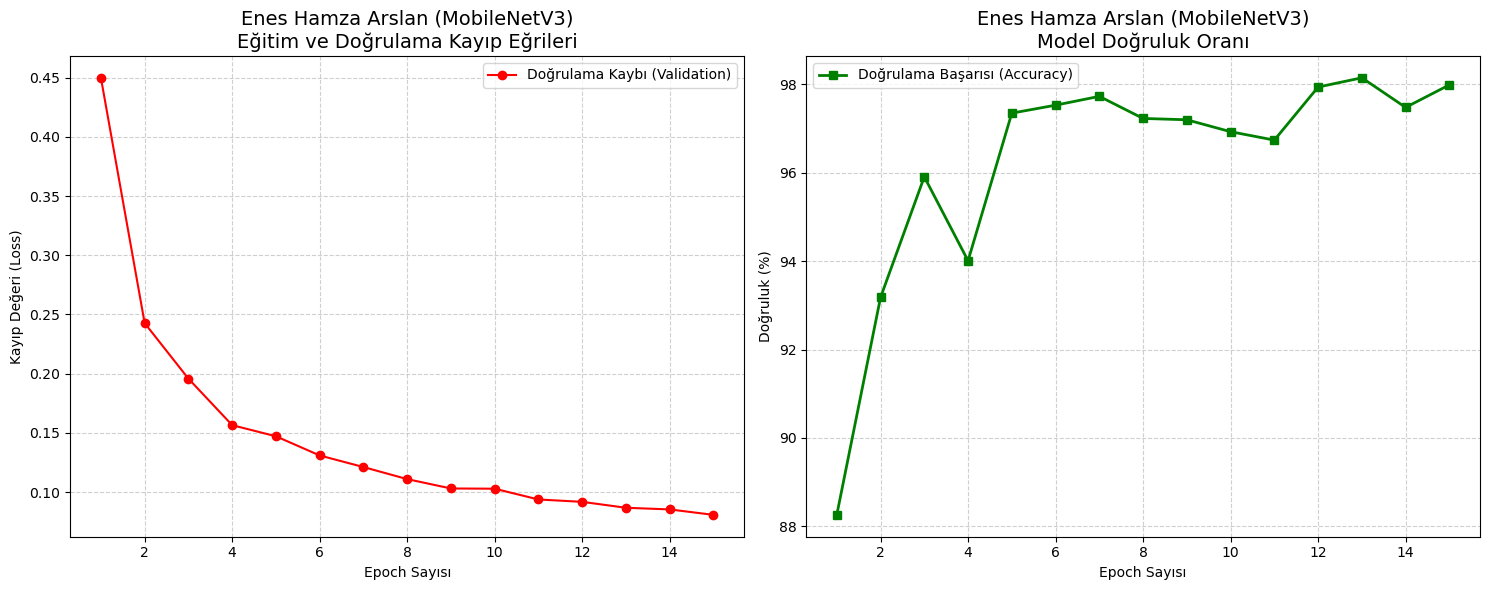

In [9]:
import matplotlib.pyplot as plt

USER_INFO = "Enes Hamza Arslan (MobileNetV3)"

epochs = list(range(1, 16))

val_losses = [0.4500, 0.2427, 0.1958, 0.1565, 0.1471, 0.1309, 0.1211, 0.1109, 0.1030, 0.1028, 0.0937, 0.0917, 0.0867, 0.0853, 0.0807]
accuracies = [88.26, 93.18, 95.91, 94.01, 97.35, 97.53, 97.73, 97.23, 97.20, 96.93, 96.74, 97.94, 98.15, 97.48, 97.99]

plt.figure(figsize=(15, 6))

# 1. Grafik: Loss (Kayıp) Değerleri
plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, 'r-o', label='Doğrulama Kaybı (Validation)')

plt.title(f'{USER_INFO}\nEğitim ve Doğrulama Kayıp Eğrileri', fontsize=14)

plt.xlabel('Epoch Sayısı')
plt.ylabel('Kayıp Değeri (Loss)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# 2. Grafik: Accuracy (Başarı) Değerleri
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'g-s', linewidth=2, label='Doğrulama Başarısı (Accuracy)')

plt.title(f'{USER_INFO}\nModel Doğruluk Oranı', fontsize=14)

plt.xlabel('Epoch Sayısı')
plt.ylabel('Doğruluk (%)')

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

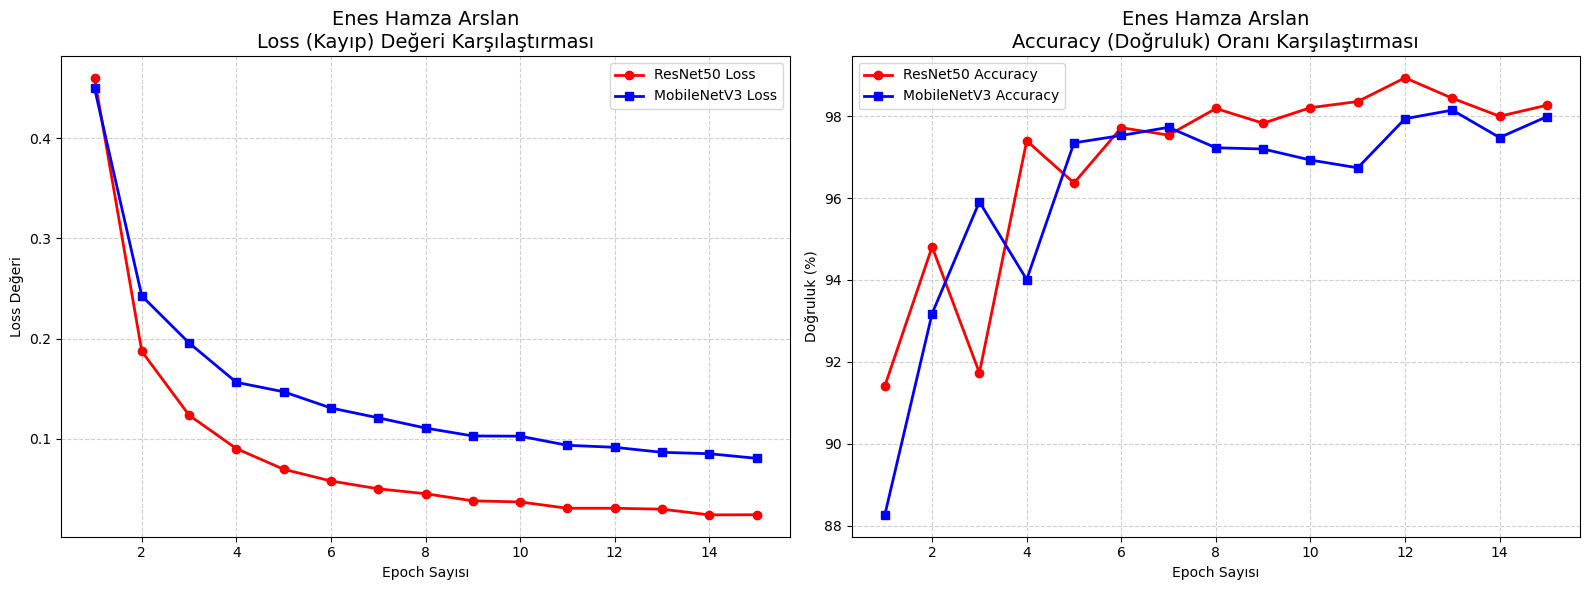

In [3]:
import matplotlib.pyplot as plt

USER_INFO = "Enes Hamza Arslan"

# Epoch Sayıları (1'den 15'e kadar)
epochs = list(range(1, 16))


# --- 1. MODEL: RESNET50 SONUÇLARI ---
resnet_losses = [0.4603,0.1874,0.1237,0.0904,0.0698,0.0581,0.0503,0.0454,0.0383,0.0372, 0.0309, 0.0309, 0.0300, 0.0243, 0.0244]
resnet_accuracies = [91.41, 94.81, 91.73, 97.40, 96.37, 97.72, 97.54, 98.19, 97.83, 98.21, 98.36, 98.94, 98.44, 98.00, 98.27]

# --- 2. MODEL: MOBILENET V3 SONUÇLARI ---
mobile_losses = [0.4500, 0.2427, 0.1958, 0.1565, 0.1471, 0.1309, 0.1211, 0.1109, 0.1030, 0.1028, 0.0937, 0.0917, 0.0867, 0.0853, 0.0807]
mobile_accuracies = [88.26, 93.18, 95.91, 94.01, 97.35, 97.53, 97.73, 97.23, 97.20, 96.93, 96.74, 97.94, 98.15, 97.48, 97.99]


# GRAFİK ÇİZDİRME


plt.figure(figsize=(16, 6))

# --- SOL GRAFİK: LOSS (KAYIP) KARŞILAŞTIRMASI ---
plt.subplot(1, 2, 1)
# ResNet Çizgisi (Kırmızı)
plt.plot(epochs, resnet_losses, 'r-o', linewidth=2, label='ResNet50 Loss')
# MobileNet Çizgisi (Mavi)
plt.plot(epochs, mobile_losses, 'b-s', linewidth=2, label='MobileNetV3 Loss')

plt.title(f'{USER_INFO}\nLoss (Kayıp) Değeri Karşılaştırması', fontsize=14)
plt.xlabel('Epoch Sayısı')
plt.ylabel('Loss Değeri')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# --- SAĞ GRAFİK: ACCURACY (BAŞARI) KARŞILAŞTIRMASI ---
plt.subplot(1, 2, 2)
# ResNet Çizgisi (Kırmızı)
plt.plot(epochs, resnet_accuracies, 'r-o', linewidth=2, label='ResNet50 Accuracy')
# MobileNet Çizgisi (Mavi)
plt.plot(epochs, mobile_accuracies, 'b-s', linewidth=2, label='MobileNetV3 Accuracy')

plt.title(f'{USER_INFO}\nAccuracy (Doğruluk) Oranı Karşılaştırması', fontsize=14)
plt.xlabel('Epoch Sayısı')
plt.ylabel('Doğruluk (%)')
 
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
from IPython.display import display

print("Analiz Yapan: Enes Hamza Arslan")

# 1. MODEL: RESNET50 VERİLERİ
resnet_acc_list = [91.41, 94.81, 91.73, 97.40, 96.37, 97.72, 97.54, 98.19, 97.83, 98.21, 98.36, 98.94, 98.44, 98.00, 98.27]
resnet_loss_list = [0.4603, 0.1874, 0.1237, 0.0904, 0.0698, 0.0581, 0.0503, 0.0454, 0.0383, 0.0372, 0.0309, 0.0309, 0.0300, 0.0243, 0.0244]

# 2. MODEL: MOBILENET V3 VERİLERİ
mobilenet_acc_list = [88.26, 93.18, 95.91, 94.01, 97.35, 97.53, 97.73, 97.23, 97.20, 96.93, 96.74, 97.94, 98.15, 97.48, 97.99]
mobilenet_loss_list = [0.4500, 0.2427, 0.1958, 0.1565, 0.1471, 0.1309, 0.1211, 0.1109, 0.1030, 0.1028, 0.0937, 0.0917, 0.0867, 0.0853, 0.0807]

# --- HESAPLAMA ---
# ResNet50 En İyi Değerler
res_best_acc = max(resnet_acc_list)
res_min_loss = min(resnet_loss_list)

# MobileNetV3 En İyi Değerler
mob_best_acc = max(mobilenet_acc_list)
mob_min_loss = min(mobilenet_loss_list)

# --- TABLO OLUŞTURMA ---
results = {
    "Model İsmi": ["ResNet50", "MobileNetV3 (Large)"],
    "En Yüksek Başarı (%)": [f"%{res_best_acc:.2f}", f"%{mob_best_acc:.2f}"],
    "En Düşük Kayıp (Loss)": [f"{res_min_loss:.4f}", f"{mob_min_loss:.4f}"],
    "Donanım": ["RTX 4060 (CUDA)", "RTX 4060 (CUDA)"]
}

df_results = pd.DataFrame(results)

print("\n" + "="*45)
print(" MODEL KARŞILAŞTIRMA TABLOSU (FİNAL) ")
print("="*45)

display(df_results)

Analiz Yapan: Enes Hamza Arslan

 MODEL KARŞILAŞTIRMA TABLOSU (FİNAL) 


Model İsmi En Yüksek Başarı (%) En Düşük Kayıp (Loss)  \
0             ResNet50               %98.94                0.0243   
1  MobileNetV3 (Large)               %98.15                0.0807   

           Donanım  
0  RTX 4060 (CUDA)  
1  RTX 4060 (CUDA)

Test Cihazı: cuda | Seçilen Model: MOBILENETV3
Veri seti hazırlanıyor...
Model mimarisi hazırlanıyor: mobilenetv3...
Ağırlıklar yükleniyor: mobilenetv3_bitki_projesi_final.pth

>>> Rastgele 16 görüntü seçiliyor ve test ediliyor... <<<
Görseller hazırlanıyor...


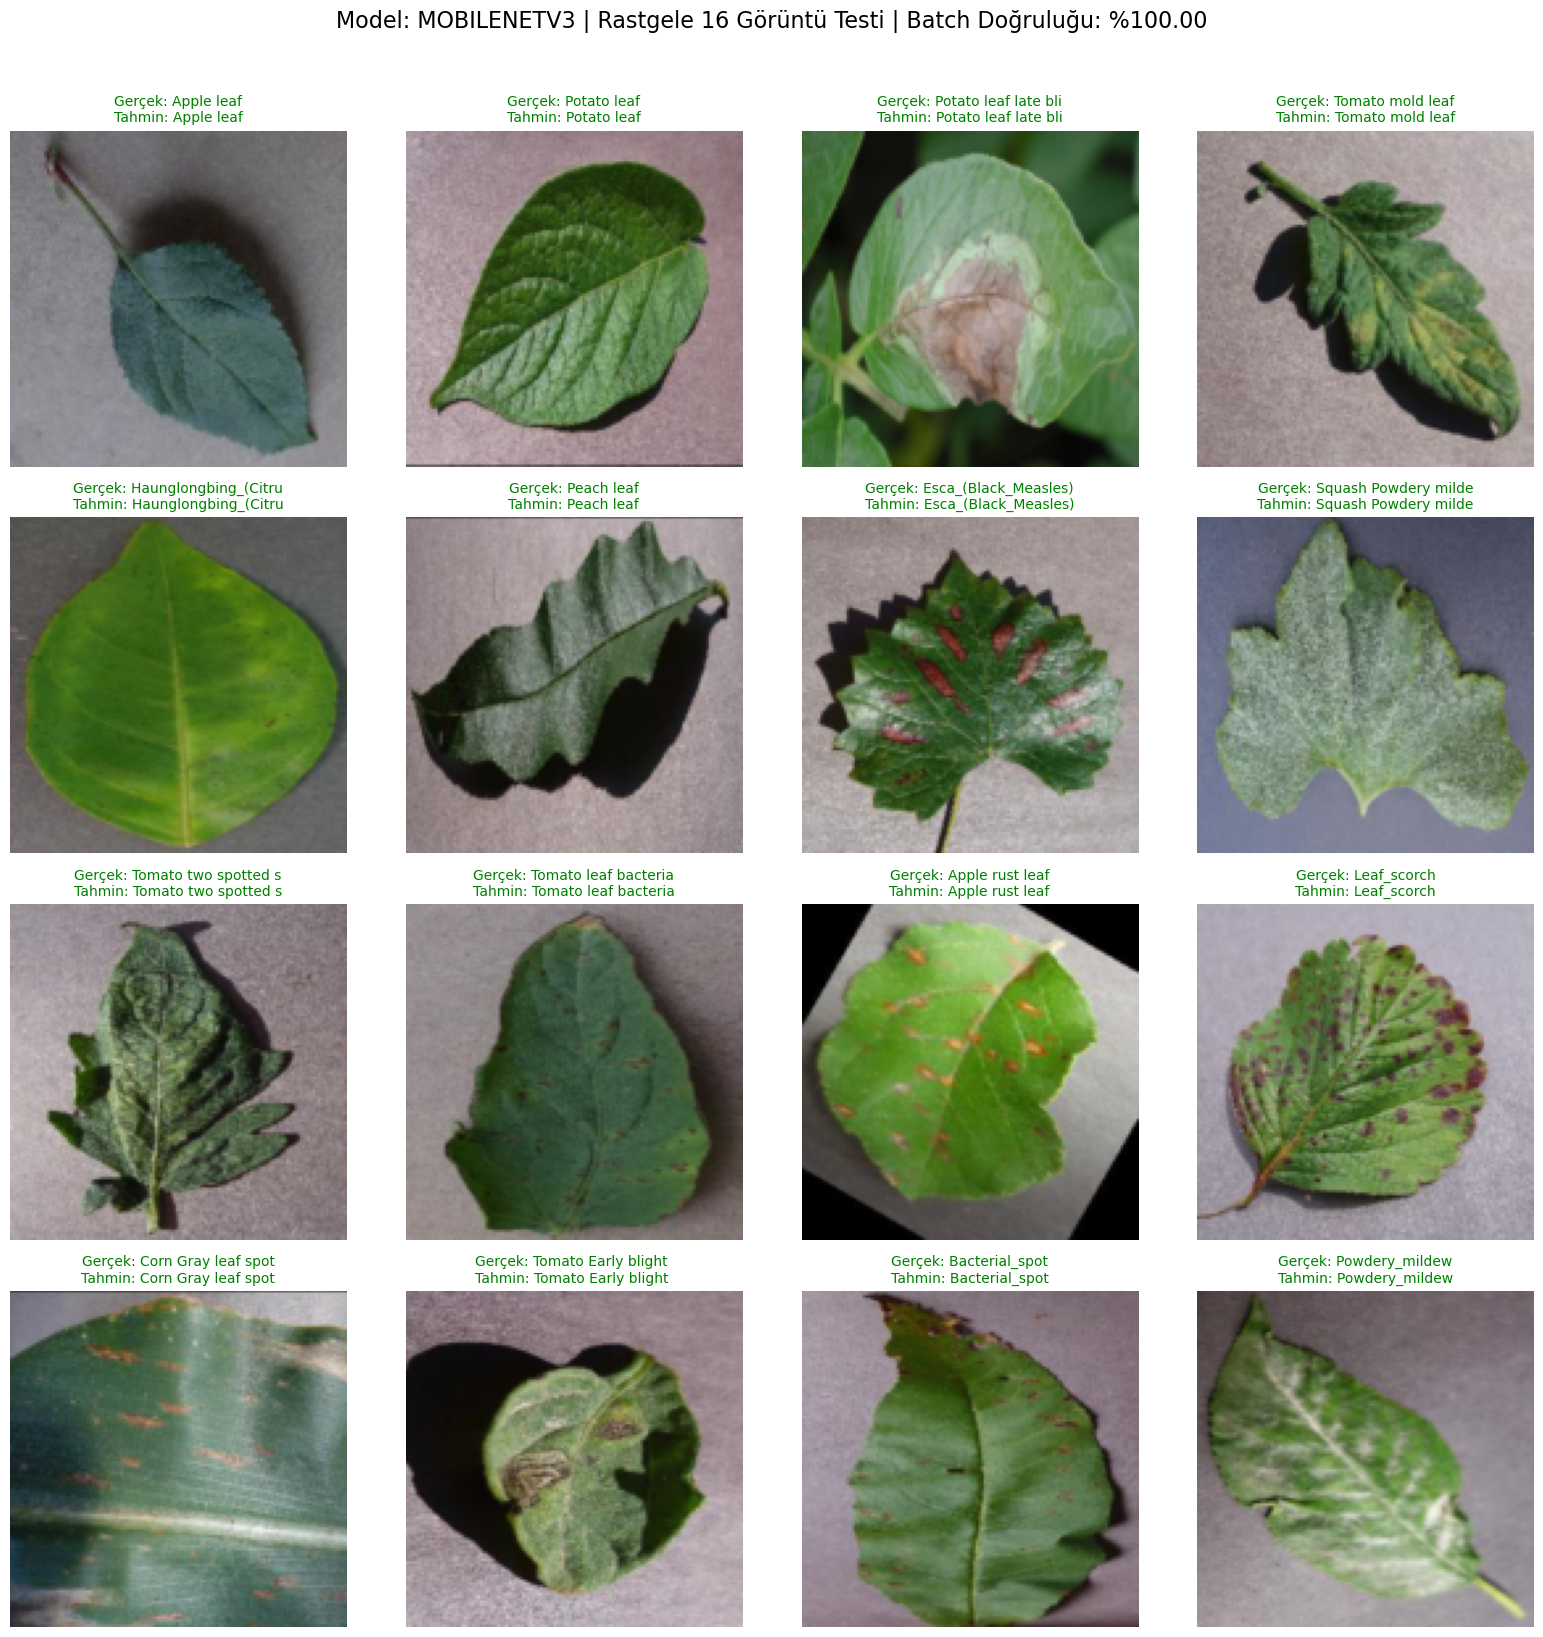

In [7]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

# ==============================================================================
# --- KONFİGÜRASYON ---
# HANGİ MODELİ TEST ETMEK İSTİYORSANIZ BURAYI DEĞİŞTİRİN:
# Seçenekler: "resnet50" veya "mobilenetv3"
MODEL_TIPI = "mobilenetv3" 
# ==============================================================================

# Yollar ve Ayarlar
CSV_DOSYASI = r'C:\Users\Enes Arslan\Bitki Projesi\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv'
ANA_KLASOR = r'C:\Users\Enes Arslan\Bitki Projesi\New Plant Diseases Dataset(Augmented)\train'
RESIM_BOYUTU = 128

# Model Yolunu Seçilen Tipe Göre Belirle
if MODEL_TIPI == "resnet50":
    MODEL_PATH = "resnet50_bitki_projesi_final.pth"
elif MODEL_TIPI == "mobilenetv3":
    MODEL_PATH = "mobilenetv3_bitki_projesi_final.pth"
else:
    raise ValueError("Geçersiz model tipi. Lütfen 'resnet50' veya 'mobilenetv3' seçin.")

# Cihaz Kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Test Cihazı: {device} | Seçilen Model: {MODEL_TIPI.upper()}")

# --- VERİ SETİ SINIFI ---
class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}
        # Sayıdan isme dönüşüm için ters sözlük
        self.idx_to_class = {i: isim for isim, i in self.sinif_sozlugu.items()}

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi = str(self.veriler.iloc[idx, 0])
            sinif_ismi = str(self.veriler.iloc[idx, 1])
            if "?" in dosya_adi: dosya_adi = dosya_adi.split('?')[0]
            
            yollar = [os.path.join(self.root_dir, sinif_ismi, dosya_adi),
                      os.path.join(self.root_dir, dosya_adi),
                      os.path.join(self.root_dir, sinif_ismi, dosya_adi[:-4] + ".jpg")]
            
            hedef_yol = None
            for yol in yollar:
                if os.path.exists(yol):
                    hedef_yol = yol
                    break
            
            if hedef_yol is None: raise FileNotFoundError()

            image = Image.open(hedef_yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform: image = self.transform(image)
            return image, label
        except:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)

# --- MODEL YÜKLEME FONKSİYONU ---
def model_yukle(model_tipi, num_classes, model_path, device):
    print(f"Model mimarisi hazırlanıyor: {model_tipi}...")
    if model_tipi == "resnet50":
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_tipi == "mobilenetv3":
        model = models.mobilenet_v3_large(weights=None)
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
    
    model = model.to(device)

    if os.path.exists(model_path):
        print(f"Ağırlıklar yükleniyor: {model_path}")
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
    else:
        raise FileNotFoundError(f"❌ Model dosyası bulunamadı: {model_path}")
    return model

# --- GÖRSELLEŞTİRME FONKSİYONU ---
def gorsellestir_ve_test_et(model, data_loader, class_map, device):
    # DataLoader'dan 1 batch (16 resim) çek
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)

    # Tahmin yap
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Verileri CPU'ya al (Görselleştirme için)
    images = images.cpu()
    preds = preds.cpu()
    labels = labels.cpu()

    # Normalizasyonu geri al (Un-normalize) - Görüntüleri eski haline döndür
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    plt.figure(figsize=(16, 16))
    correct_count = 0

    print("Görseller hazırlanıyor...")
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)

        # Tensor'u numpy dizisine çevir ve boyutları ayarla (CHW -> HWC)
        img = images[i].numpy().transpose((1, 2, 0))
        img = std * img + mean # Normalizasyonu geri al
        img = np.clip(img, 0, 1) # Renk değerlerini 0-1 arasına sabitle
        plt.imshow(img)

        # İsimleri al
        actual_label = class_map[labels[i].item()]
        predicted_label = class_map[preds[i].item()]

        # Doğruysa YEŞİL, Yanlışsa KIRMIZI başlık
        color = 'green' if preds[i] == labels[i] else 'red'
        if preds[i] == labels[i]: correct_count += 1

        # Başlıkları biraz kısaltalım ki sığsın (İsteğe bağlı)
        actual_short = actual_label.split('___')[-1][:20]
        predicted_short = predicted_label.split('___')[-1][:20]
        
        title = f"Gerçek: {actual_short}\nTahmin: {predicted_short}"
        ax.set_title(title, color=color, fontsize=10)
        plt.axis('off')

    batch_acc = (correct_count / 16) * 100
    plt.suptitle(f"Model: {MODEL_TIPI.upper()} | Rastgele 16 Görüntü Testi | Batch Doğruluğu: %{batch_acc:.2f}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# --- ANA ÇALIŞMA BLOĞU ---
if __name__ == '__main__':
    # Dönüşümler
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    print("Veri seti hazırlanıyor...")
    full_dataset = TankVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)

    # Test verisinden rastgele seçim yapmak için ayırıyoruz
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    _, val_dataset = random_split(full_dataset, [train_size, val_size])

    # DataLoader: batch_size=16 ve shuffle=True yaparak rastgele 16'lı paketler oluşturuyoruz
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0)

    # Modeli Yükle
    num_classes = len(full_dataset.sinif_isimleri)
    try:
        model = model_yukle(MODEL_TIPI, num_classes, MODEL_PATH, device)
        
        # Görselleştir ve Test Et
        print("\n>>> Rastgele 16 görüntü seçiliyor ve test ediliyor... <<<")
        gorsellestir_ve_test_et(model, val_loader, full_dataset.idx_to_class, device)

    except Exception as e:
        print(f"\nBir hata oluştu: {e}")

Test Cihazı: cuda | Seçilen Model: RESNET50
Veri seti hazırlanıyor...
Model mimarisi hazırlanıyor: resnet50...
Ağırlıklar yükleniyor: resnet50_bitki_projesi_final.pth

>>> Rastgele 16 görüntü seçiliyor ve test ediliyor... <<<
Görseller hazırlanıyor...


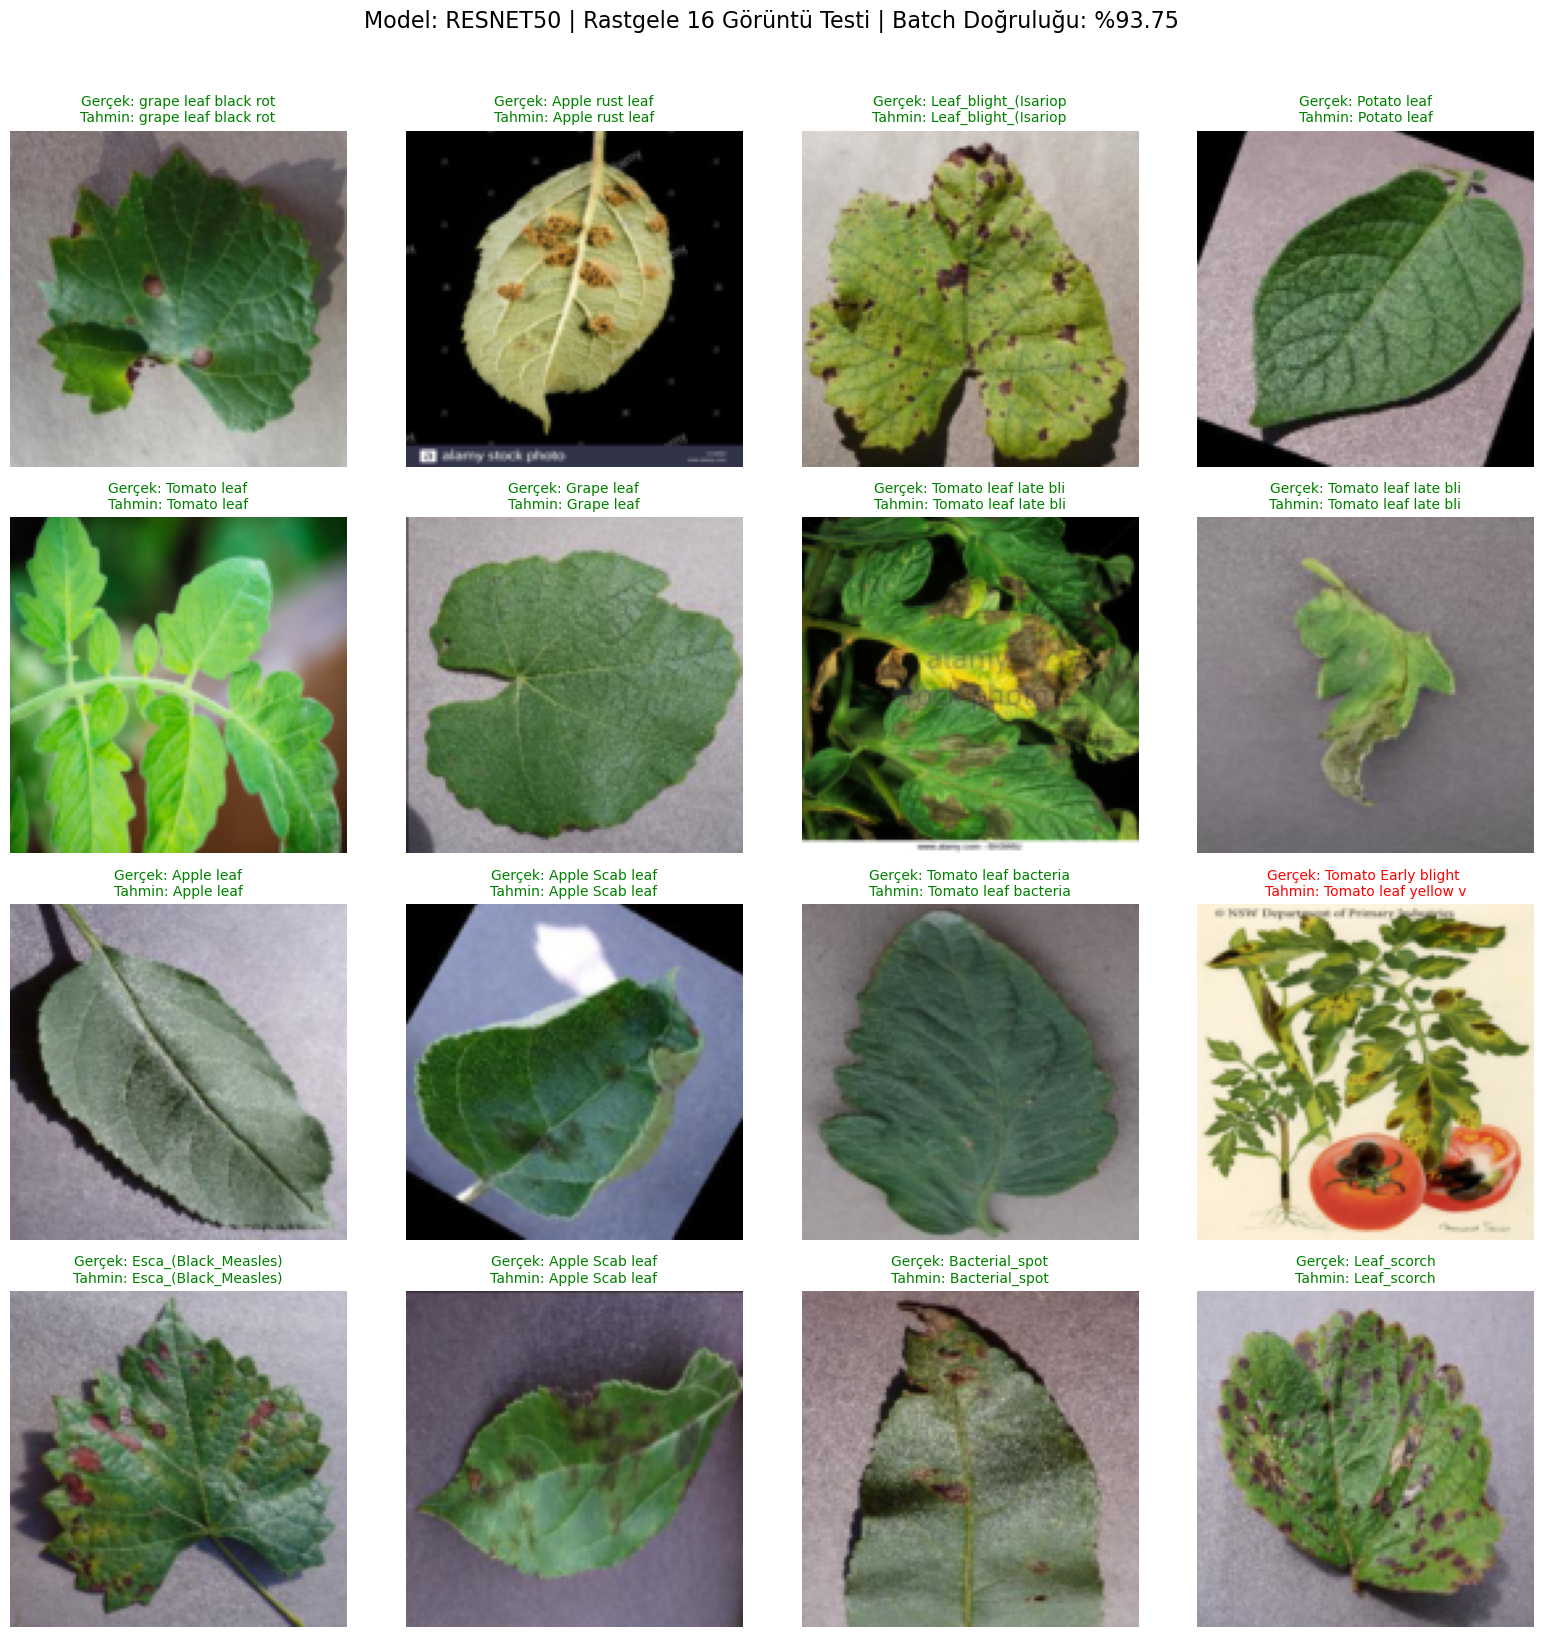

In [8]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

# ==============================================================================
# --- KONFİGÜRASYON ---
# HANGİ MODELİ TEST ETMEK İSTİYORSANIZ BURAYI DEĞİŞTİRİN:
# Seçenekler: "resnet50" veya "mobilenetv3"
MODEL_TIPI = "resnet50" 
# ==============================================================================

# Yollar ve Ayarlar
CSV_DOSYASI = r'C:\Users\Enes Arslan\Bitki Projesi\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv'
ANA_KLASOR = r'C:\Users\Enes Arslan\Bitki Projesi\New Plant Diseases Dataset(Augmented)\train'
RESIM_BOYUTU = 128

# Model Yolunu Seçilen Tipe Göre Belirle
if MODEL_TIPI == "resnet50":
    MODEL_PATH = "resnet50_bitki_projesi_final.pth"
elif MODEL_TIPI == "mobilenetv3":
    MODEL_PATH = "mobilenetv3_bitki_projesi_final.pth"
else:
    raise ValueError("Geçersiz model tipi. Lütfen 'resnet50' veya 'mobilenetv3' seçin.")

# Cihaz Kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Test Cihazı: {device} | Seçilen Model: {MODEL_TIPI.upper()}")

# --- VERİ SETİ SINIFI ---
class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}
        # Sayıdan isme dönüşüm için ters sözlük
        self.idx_to_class = {i: isim for isim, i in self.sinif_sozlugu.items()}

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi = str(self.veriler.iloc[idx, 0])
            sinif_ismi = str(self.veriler.iloc[idx, 1])
            if "?" in dosya_adi: dosya_adi = dosya_adi.split('?')[0]
            
            yollar = [os.path.join(self.root_dir, sinif_ismi, dosya_adi),
                      os.path.join(self.root_dir, dosya_adi),
                      os.path.join(self.root_dir, sinif_ismi, dosya_adi[:-4] + ".jpg")]
            
            hedef_yol = None
            for yol in yollar:
                if os.path.exists(yol):
                    hedef_yol = yol
                    break
            
            if hedef_yol is None: raise FileNotFoundError()

            image = Image.open(hedef_yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform: image = self.transform(image)
            return image, label
        except:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)

# --- MODEL YÜKLEME FONKSİYONU ---
def model_yukle(model_tipi, num_classes, model_path, device):
    print(f"Model mimarisi hazırlanıyor: {model_tipi}...")
    if model_tipi == "resnet50":
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_tipi == "mobilenetv3":
        model = models.mobilenet_v3_large(weights=None)
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
    
    model = model.to(device)

    if os.path.exists(model_path):
        print(f"Ağırlıklar yükleniyor: {model_path}")
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
    else:
        raise FileNotFoundError(f"❌ Model dosyası bulunamadı: {model_path}")
    return model

# --- GÖRSELLEŞTİRME FONKSİYONU ---
def gorsellestir_ve_test_et(model, data_loader, class_map, device):
    # DataLoader'dan 1 batch (16 resim) çek
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)

    # Tahmin yap
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Verileri CPU'ya al (Görselleştirme için)
    images = images.cpu()
    preds = preds.cpu()
    labels = labels.cpu()

    # Normalizasyonu geri al (Un-normalize) - Görüntüleri eski haline döndür
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    plt.figure(figsize=(16, 16))
    correct_count = 0

    print("Görseller hazırlanıyor...")
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)

        # Tensor'u numpy dizisine çevir ve boyutları ayarla (CHW -> HWC)
        img = images[i].numpy().transpose((1, 2, 0))
        img = std * img + mean # Normalizasyonu geri al
        img = np.clip(img, 0, 1) # Renk değerlerini 0-1 arasına sabitle
        plt.imshow(img)

        # İsimleri al
        actual_label = class_map[labels[i].item()]
        predicted_label = class_map[preds[i].item()]

        # Doğruysa YEŞİL, Yanlışsa KIRMIZI başlık
        color = 'green' if preds[i] == labels[i] else 'red'
        if preds[i] == labels[i]: correct_count += 1

        # Başlıkları biraz kısaltalım ki sığsın (İsteğe bağlı)
        actual_short = actual_label.split('___')[-1][:20]
        predicted_short = predicted_label.split('___')[-1][:20]
        
        title = f"Gerçek: {actual_short}\nTahmin: {predicted_short}"
        ax.set_title(title, color=color, fontsize=10)
        plt.axis('off')

    batch_acc = (correct_count / 16) * 100
    plt.suptitle(f"Model: {MODEL_TIPI.upper()} | Rastgele 16 Görüntü Testi | Batch Doğruluğu: %{batch_acc:.2f}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# --- ANA ÇALIŞMA BLOĞU ---
if __name__ == '__main__':
    # Dönüşümler
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    print("Veri seti hazırlanıyor...")
    full_dataset = TankVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)

    # Test verisinden rastgele seçim yapmak için ayırıyoruz
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    _, val_dataset = random_split(full_dataset, [train_size, val_size])

    # DataLoader: batch_size=16 ve shuffle=True yaparak rastgele 16'lı paketler oluşturuyoruz
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0)

    # Modeli Yükle
    num_classes = len(full_dataset.sinif_isimleri)
    try:
        model = model_yukle(MODEL_TIPI, num_classes, MODEL_PATH, device)
        
        # Görselleştir ve Test Et
        print("\n>>> Rastgele 16 görüntü seçiliyor ve test ediliyor... <<<")
        gorsellestir_ve_test_et(model, val_loader, full_dataset.idx_to_class, device)

    except Exception as e:
        print(f"\nBir hata oluştu: {e}")